# COGS 108 - Final Project 

# Overview

To help improve the restaurant health inspection process, my project explores if Yelp review ratings could help identify which restaurants require a higher priority health inspection. I hypothesized that a restaurant’s Yelp rating does have a relation with its inspection score, and with this relation, health inspectors could identify which restaurants have a low Yelp review score and make them a priority to perform a health inspection. Having done the analysis, the information shows that there is indeed a relation between a restaurant's Yelp rating and its inspection score, with every increase in a rating expecting their inspection score to increase by 2.26. This predictive analysis could help inspectors to identify which restaurants require a higher priority inspection, leading to more citations and making a healthier environment for customers.

# Name & PID

- Name: Laith Bayyari
- PID: A15311932

# Research Question

Could Yelp reviews help to identify which restaurants are a higher priority candidate for a health inspection?

## Background and Prior Work

1) Most health inspections are done at random. Meaning that time could be wasted inspecting a restaurant that already abides by health inspection rules and resources would be wasted. Sorrata, a cloud base service, has sought out to solve this inefficiency in health inspections by partnering with Yelp to figure out which restaurants are viewed as having bad health regulations at their restaurants through keywords in the Yelp reviews. By observing negative connotative words such as 'bug' or 'dirty' in Yelp reviews, Yelp "correctly classify more than 80 percent of restaurants into either the top half or bottom half of hygiene scores." Thus, Yelp has begun to create an algorithm to help point health inspectors in the direction of potential restaurants that are more likely to receive a low inspection score. (Link: https://gcn.com/articles/2015/03/02/yelp-city-restaurant-inspections.aspx)

2) The health inspection process is a painstaking procedure. Health inspectors take their checkups seriously as a bad inspection could lead to injuries or even death in a restaurant. The problem is on a given day, a health inspector would cite fewer violations through each successive inspection due to the toll it takes to inspect each restaurant. Health inspections are done at random and so there wouldn't be a set of preliminary rules to identify which restaurant should take higher priority. However, it has been shown that by increasing the frequency of restaurant health inspections, there were more citations and more opportunities to create a healthier environment for customers. Thus, if there was some way to make use of the health inspectors' time, they could do more health inspections and prevent more disasters to occur for a given customer when visiting a restaurant. (Link: https://hbr.org/2019/05/to-improve-food-inspections-change-the-way-theyre-scheduled)

# Hypothesis


I believe we will see a relation between a restaurant's Yelp review rating and its inspection score, with a lower rating corresponding to a lower inspection score. With this information, we could identify which restaurants have a low Yelp review score and make them a priority to perform a health inspection.

# Dataset(s)

#### Dataset Name: yelp.csv
- Link to the dataset: Provided by the professor.
- Number of observations: 31
- Description: This dataset contains the Yelp review ratings of various restaurants. It mainly contains the review rating, the number of reviews, and the cuisine of a specific restaurant.

#### Dataset Name: inspection.csv
- Link to the dataset: Provided by the professor.
- Number of observations: 36
- Description: This dataset contains an inspection score of various restaurants. Highlighting the locations of the restaurants, their inspection score, and sub scores as well.


- I plan to combine the Yelp data and Inspection data by merging them based on their longitude and latitude columns.

#### Dataset Name: violation.csv
- Link to the dataset: Provided by the professor.
- Number of observations: 18
- Description: This dataset contains violations that various restaurants have committed. Highlighting the type of violation and a point value showing the number of violations they have committed.


-  I plan to combine the Violation data with the merged Inspection & Rating data. I will merge these data frames based on the 'hsisid' column, an id given for each restaurant in the inspection and violation data frames.

# Setup

Tools for using regression and plotting out results

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, normaltest

# Data Cleaning

### Cleaning Yelp Data

* Here I focused on removing the unwanted data as I only wanted the rating score and review amount of the various restaurants.
    * I removed the cuisine type, whether a restaurant is closed and its name.
    
* I then proceed to focus on review scores that matter, meaning review scores with a significant number of reviewers that contributed to the score.
    * I decided to get the 25 percentile of the review count (six in this case) and use that to only get rows that had review count greater than or equal to the 25 percentile.


In [2]:
# Cleaning Yelp Data

df_yelp = pd.read_csv("yelp.csv")
df_yelp = df_yelp.drop(['price', 'hotdogs','sandwiches','pizza','tradamerican',
              'burgers','mexican','grocery','breakfast_brunch',
              'coffee','chinese','italian','newamerican',
              'chicken_wings','delis','bars','salad','seafood','bbq','bakeries','sushi', 'phone', 'is_closed', 'name'],axis=1)

# Since there are various amounts of review counts I've decided to only get restaurants with reviews >= to
# the 25% quantile of all review counts

quan25Reviews = df_yelp.review_count.quantile(0.25)
df_yelp = df_yelp[df_yelp['review_count'] >= quan25Reviews]
df_yelp.columns = ['id', 'rating', 'review_count', 'address1', 'zip_code', 'y', 'x']
average_rating = df_yelp['rating'].mean()

### Cleaning Inspection Data

* Here I focused on removing the unwanted data as I only wanted the inspection score of various restaurants.
    * I removed the subcategories of an inspection, and private information such as name, zip code and postal code.
    
* I then proceeded to remove duplicate observations as most restaurants had multiple inspections.
    * I decided to only keep the most up-to-date inspection for a restaurant and to remove old inspection scores.

In [3]:
# Cleaning Inspection Data

df_inspec = pd.read_csv("inspections.csv")
df_inspec = df_inspec.drop(['num_critical','num_non_critical','num_critical_previous','num_non_critical_previous',
                            'num_critical_mean_previous','num_non_critical_mean_previous',
                            'avg_neighbor_num_critical','avg_neighbor_num_non_critical','top_match','second_match','critical',
                           'postalcode', 'phonenumber', 'facilitytype', 'type', 'description', 'inspectedby',
                           'previous_inspection_date','days_since_previous_inspection','previous_inspection_by_same_inspector',
                           'geocodestatus', 'restaurantopendate','days_from_open_date'], axis=1)
df_inspec.head()
average_inspec = df_inspec['score'].mean()

# Used the most up to date inspection for each resteraunt
df_inspec = df_inspec.sort_values(['date']).drop_duplicates(subset = 'hsisid', keep = 'last')

### Merging Yelp and Inspection Data Frames

* After having cleaned up both the Yelp and Inspection data I needed to merge the data frames to match a restaurant’s review rating with its inspection score. 
    * I noticed that both the Yelp and Inspection Data had longitude and latitude for each row. I changed the column names of the Yelp data from latitude and longitude to y and x respectively to match the name in the Inspection Data.
    * Having done the renaming, I then proceeded to merge both data frames based on their x and y columns.
    * I then proceeded to remove private information of each restaurant such as the name, the location, the zip code, and address.
    * I finally dropped any rows where there was a missing value in a row's rating or score column.

In [4]:
# Merge Data Frames

df_merged = pd.merge(df_yelp, df_inspec, on=['x','y'])
df_merged = df_merged.dropna(subset=['rating', 'score'])

# Protect the privacy of the resteraunts
df_merged = df_merged.drop(['name', 'x', 'y', 'zip_code', 'address1_y', 'address1_x', 'zip', 'zip_code',
                           'address1_x', 'zip_code', 'address2', 'id'], axis=1)


### Cleaning Violation Data

* Here I focused created the violations data frame and merging it with the merged inspection & rating data frame. I then proceeded to drop any rows where their rating, score, or point value were missing.

In [5]:
# Cleaning Violation Data

df_viol = pd.read_csv('violations.csv')
df_violMerged = pd.merge(df_merged, df_viol, on=['hsisid'])
df_violMerged = df_violMerged.dropna(subset=['rating', 'score', 'pointvalue'])

# Data Analysis & Results

### Plotting The Distribution of Inspection Scores

Here I plotted a histogram of the inspection scores from the merged data frame. Thereby, showing us a visual representation of the distribution of inspection scores across various restaurants. From the graph, we see that most restaurants have an inspection score around 96 with the least number of restaurants hovering over the scores 80 - 90. From the overall graph, we can observe that the data does seem to be normally distributed.

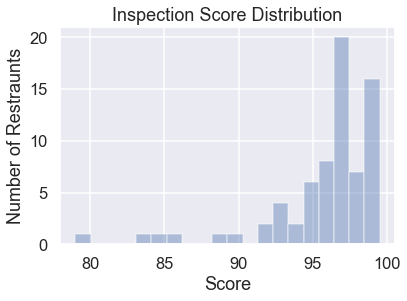

In [6]:
# Plot the distribution of inspection score

f1 = sns.distplot(df_merged['score'], kde=False, bins=20);
f1.set_title('Inspection Score Distribution')
f1.set_ylabel("Number of Restraunts")
f1.set_xlabel("Score")
f1 = plt.gcf()

### Plotting The Distribution of Review Ratings

Here I decided to plot the number of restaurants that were in each rating category. This allows us to get a visual representation of the distributions of review ratings across the restaurant. We observe that most restaurants have a 3.5 and 4.0 rating out of 5. With the least number of restaurants having a rating of 2.0. Just from the overall observation we can see that there does seem to be a normal distribution of the rating data across various restaurants. The colors of the graph were chosen to reflect what users usually have seen when rating out of five, starting from red and ending at blue, with shades of orange, yellow and green in between (https://reviewinc.com/2015/12/24/it-matters-color-of-your-star-ratings/).

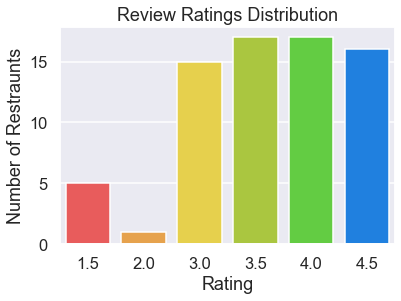

In [7]:
# Plot the distribution of ratings score

g1 = sns.countplot(x="rating", data=df_merged, palette=["#ff4545", "#ffa534", '#ffe234', '#b7dd29', '#57e32c', '#0080ff'])
g1.set_title('Review Ratings Distribution')
g1.set_ylabel("Number of Restraunts")
g1.set_xlabel("Rating")
g1 = plt.gcf()

### Testing Normal Distribution

I wanted to make sure that before proceeding with any sort of regression I wanted to know whether both the inspection score data and review rating data meet the assumption of being normally distributed. I first retrieved the values of the inspection score and review ratings from the merged data frame. With this data, I used the normal test function to get the statistic value and p-value of both the inspection score and review ratings.

I then proceeded to check whether we had evidence to reject the null hypothesis ("we cannot use Yelp scores to identify which restaurants require higher priority health inspection"). I used the alpha significance value 0.01 as this meant that there would be a 1% risk of being incorrect about my hypothesis. In the end, both the p-values of the inspection scores and the rating scores were below the alpha value and thus, we proved there were normally distributed, and we could move on with our analysis.

In [8]:
# Testing Distributions

scores = df_merged['score'].values
ratings = df_merged['rating'].values

In [9]:
st_score, p_score = normaltest(scores)
st_rating, p_rating = normaltest(ratings)

In [10]:
def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')
        
check_p_val(p_score, 0.01)
check_p_val(p_rating, 0.01)

We have evidence to reject the null hypothesis.
We have evidence to reject the null hypothesis.


### Visualization The Normal Distribution Of Inspection Scores

With the confirmation that there is indeed a normal distribution for the inspection scores, I plotted the normal distribution against the actual data of the inspection data for visual purposes. We can indeed see from the graph that there is a normal distribution curve of the actual data. Regarding design choices, the colors orange and blue were chosen to represent the data as they are shown as contrasting colors according to the color wheel.

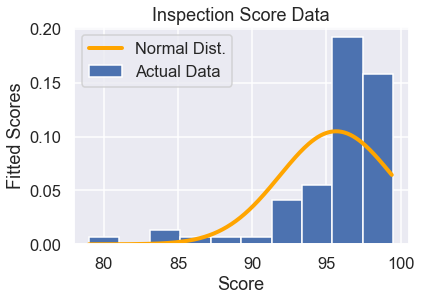

In [11]:
# Visualize Data

scoresArr = np.arange(scores.min(), scores.max(), 0.1)
fit = stats.norm.pdf(scoresArr, np.mean(scores), np.std(scores))
plt.plot(scoresArr, fit, label = 'Normal Dist.', lw = 4, color = "orange")
plt.hist(scores, density = True, label = 'Actual Data');
plt.title('Inspection Score Data')
plt.ylabel("Fitted Scores")
plt.xlabel("Score")
plt.legend();

 ### Visualization The Normal Distribution Of Review Ratings

Much like the inspection score, we confirmed that the review rating data is normally distributed. Now we can visually see this confirmation by plotting the normal distribution curve of the rating data against the actual data. We can indeed see from the graph that the data has a normal distribution curve. Regarding design choices, the colors yellow and purple were chosen to represent the data as these colors as they are contrasting colors according to the color wheel.

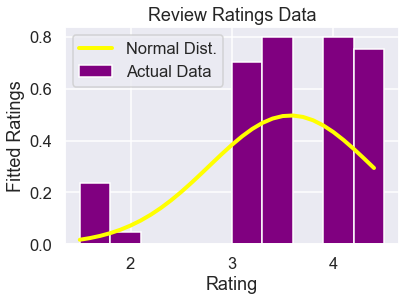

In [12]:
# Visualize Data

ratingsArr = np.arange(ratings.min(), ratings.max(), 0.1)
fit = stats.norm.pdf(ratingsArr, np.mean(ratings), np.std(ratings))
# most easily done using matplotlib
plt.plot(ratingsArr, fit, label = 'Normal Dist.', lw = 4, color = "yellow")
plt.hist(ratings, density = True, label = 'Actual Data', color = "purple");
plt.title('Review Ratings Data')
plt.ylabel("Fitted Ratings")
plt.xlabel("Rating")
plt.legend();

### Comparing Inspection Score vs Rating Distributions

Now that we have seen that both the inspection score and review ratings are indeed normally distributed. We could now see if they are related. I decided to use the ttest_ind function to see whether a relation between the two data was existed. Having retrieved the p-value from the function, it was indeed less than the alpha value of 1% meaning there was a high chance that the inspection score and rating data were related. This has concluded our first pass analysis, allowing us to continue to confirm whether my hypothesis holds.

In [13]:
# Compare Distrutibions of Inspection Score & Rating

t_val, p_val = ttest_ind(scores, ratings)

if p_val < 0.01:
    print('There is a significant difference')
else:
    print('There is NOT a significant difference')
    
# First pass hows there is a significant difference

There is a significant difference


### Linear Regression On The Inspection Score & Rating

Using the pasty library, I used linear regression on the inspection score and rating data to come up with a summary detailing the relationship between a restaurant's rating and its inspection score. Here we can observe that for every 1 increase in a restaurant’s rating, their inspection score is expected to increase by 2.26 with a standard error of 0.5. This shows that a restaurant’s rating significantly predicts its inspection score.

In [14]:
# Attempt to use linear model to see if we can predict Inspection Score From Rating

outcome_1, predictors_1 = patsy.dmatrices('score ~ rating',df_merged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     20.48
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           2.45e-05
Time:                        23:50:30   Log-Likelihood:                -186.30
No. Observations:                  71   AIC:                             376.6
Df Residuals:                      69   BIC:                             381.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.5531      1.833     47.754      0.0

### Visualize Prediction Equation

To better understand the model, I decided to create a scatter plot using the ratings from our data frame and used our prediction equation to predict their inspection score. This helps us observe whether our prediction equation is performing correctly through the linearity of the prediction model. From the graph we see that the prediction line is indeed linear and is in the direction the actual data is facing. Showing us that the prediction equation is accurate in predicting an inspection score based on a restaurant’s rating.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


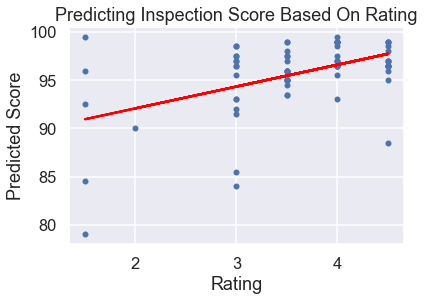

In [15]:
# Mathematical Equation For Predicting Inspection Score:

def predictInspection(rating):
    return 87.5531 + (2.2627 * rating)

# Visualize Predictions

pred_ratings = df_merged['rating']
pred_ratings = (pred_ratings * 2.2627) + 87.5531

df_merged.plot.scatter(x = 'rating', y = 'score')
plt.plot(df_merged['rating'], pred_ratings, color = 'red' )
plt.title('Predicting Inspection Score Based On Rating')
plt.ylabel("Predicted Score")
plt.xlabel("Rating")
g = plt.gcf()

### Exploring Confounding Variables

Although I have shown there is a relation between a restaurant's rating and its inspection score, I wanted to make sure that I covered most bases by exploring confounding variables that may better identify whether a restaurant requires a higher priority health inspection. I decided to look at whether a restaurant’s violation record could relate to its health inspection score. 

I first tested whether there was any significant relationship between a restaurant's violation record and their inspection score using the ttest_ind function. After using the function, we observe that there was indeed a significant relationship as the p-value was less than the alpha value of 1%.

In [16]:
# Testing Distributions
violations = df_violMerged['pointvalue'].values

t_val, p_val = ttest_ind(scores, violations)

if p_val < 0.01:
    print('There is a significant difference')
else:
    print('There is NOT a significant difference')

There is a significant difference


### Linear Regression On The Inspection Score & Violation Point Value

After confirming that there was a relation between the inspection score data and violation data, I used linear regression on both data to come up with a summary detailing the relationship between a restaurant's violation record and its inspection score. Here we can observe that for an increase in a restaurant’s violation point value, their inspection score is expected to decrease by 0.0166 with a standard error of 0.154. 

This shows that there is indeed a relation between a restaurant's violation point value amount and their inspection score. However, a restaurant's rating better predicts their inspection score and therefore is still the best choice when identifying if a restaurant requires a high priority health inspection.

In [17]:
outcome_1, predictors_1 = patsy.dmatrices('score ~ pointvalue',df_violMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01164
Date:                Sun, 07 Jun 2020   Prob (F-statistic):              0.914
Time:                        23:50:31   Log-Likelihood:                -9436.3
No. Observations:                3110   AIC:                         1.888e+04
Df Residuals:                    3108   BIC:                         1.889e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.1754      0.107    876.159      0.0

In [18]:
# Equation For Prediction An Inspection Score Based On Violation Point Value
def predictInspectionVio(pointValue):
    return 94.1754 + (2.2627 * -0.0166)

# Ethics & Privacy

The data given is from Yelp's database, and the health inspection organization, all of which is available for the public, and therefore I have permission to use the data for analytical purposes. Although the location and name of the restaurants are prevalent from the original data, I made the effort of privatizing the data to help protect the locations and names of the restaurants from my analysis. Once I retrieved the original data, I removed the names, locations (longitude and latitude), zip codes, name ids, and postal codes to protect the identity of the restaurants.

There are potential biases in the data in the sense that there is human bias in the reviews given to a restaurant. Although I am analyzing whether a rating could predict an inspection score, a person may have given a bad review due to them disliking the food and not necessarily rating the health environment of the restaurant. To handle this issue, I have provided a standard deviation for each prediction to account for this human bias (although this of course is not fully accurate). 

Regarding equitable impact, health inspectors could use my predictive equation to predict what a restaurant's health inspection score could be. However, once they do have a number in mind, they may be biased inspecting the said restaurant as subconsciously they may want to give a number close to the predicted one. This may be hurtful for a business whose reviews may be based on qualities other than the health regulations of their environment. This would ultimately cause my analysis to be used for an unjust cause and not a fair one. To handle this problem, I will make it explicitly clear that the predictive equation is not perfect as it does not have use only ratings that were reviews discussing the health concerns of the restaurants. Rather the predictive equation is more of an indication of which restaurants to observe and not necessarily what health inspectors should base their final score on.

# Conclusion & Discussion

My project focuses on the relationship between a restaurants' inspection score and review rating. More specifically, I wanted to know if Yelp reviews could help to identify which restaurants need a higher priority health inspection. I attempt to verify the correctness of my hypothesis:  there is a relation between a restaurant's Yelp review rating and its inspection score and with this information, we could identify which restaurants have a low Yelp review rating and make them a priority to perform a health inspection. This would help make health inspections more efficient by removing the randomness of choosing which restaurant to perform an inspection and help to give out more citations to prevent more violations and disasters for a customer.

I focused on using the Yelp, inspection, and violation data to help validate my hypotheses. For the cleaning process, I removed unwanted data such as cuisine type from the Yelp data, subcategories in the inspection data, and violation type from the violation data. I then proceeded to merge the Yelp and inspection data so I could match the inspection scores for a restaurant and their rating score. For the data analysis, I wanted to verify whether it was possible to do a line regression between the inspection score variable and rating variable of a restaurant, by verifying if the data was normally distributed and using the t-test function to see if there was a significant relationship between the two variables. Having used the pasty library I was able to see that for every 1 increase in a restaurant rating their inspection score was expected to go up by 2.26. Showing that we could indeed use a restaurant’s rating to observe their expected inspection score.

To make sure I covered my bases, I also looked at a cofounding variable, the violation point value of a restaurant to see if this variable was more responsible for a restaurant's inspection score. Having done the same analysis as the inspection and rating variable I found that there was indeed a relation between a restaurant's inspection score and their violation point value. Mainly for each 1 increase in a restaurant’s point value their inspection score was predicted to decrease by 0.0166. However, the review rating still provided a better way to identify which restaurant would have a lower inspection score. Thus, my hypothesis still holds.

My analysis, however, does have some limitations. First of all, it is difficult to understand what the Yelp reviews are as they are just review scores and the data doesn't include the reviews themselves. Perhaps a rating for a restaurant is low due to the customer bias of the food and would have nothing to do with the actual health environment. Therefore, the rating for each restaurant is ambiguous and it would have been better to only account for reviews that mentioned the health concern of the restaurant itself. Therefore, it should be noted that my predictive equation should only be used to give a general idea about which restaurants an inspector should inspect first and not necessarily should be used to give the final inspection score. Moreover, since the Yelp data did not have a 'date' column for the ratings, I could not figure out which inspection score to use for each restaurant and ultimately decided to use the most up-to-date inspection score for a given restaurant. This may skew the results as the rating score given would perhaps not match the inspection score I matched with.

In the end, we have shown that a restaurant's Yelp review rating could help to predict its inspection score. Health inspectors could use a restaurant's current review rating to see what their potential inspection score could be before accepting an inspection. This could help them target more potential restaurants that would have low health regulations and provide more citations while being more efficient with their time. Ultimately increasing the average citations given and making the restaurant environments safer for customers.